In [16]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
import mygene
%matplotlib inline
import pickle
import sklearn
import random
import scanpy as sc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import openai
# remember to set your open AI API key!
openai.api_key = ''
np.random.seed(202310)
# use hnswlib for NN classification
try:
    import hnswlib
    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print("hnswlib not installed! We highly recommend installing it for fast similarity search.")
    print("To install it, run: pip install hnswlib")
from scipy.stats import mode

### Load sampled Aorta data, available at https://drive.google.com/drive/folders/1LgFvJqWNq9BqHbuxB2tYf62kXs9KqL4t?usp=share_link

In [7]:
sampled_adata = sc.read_h5ad("./sample_aorta_data_updated.h5ad")

/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
mapping_dict_phenotype = {
 'affected_1': 'Ascending only',
 'affected_2': 'Ascending only',
 'affected_3': 'Ascending w/ root',
 'affected_4': 'Ascending only',
 'affected_5': 'Ascending w/ root',
 'affected_6': 'Ascending to descending',
 'affected_7': 'Ascending w/ root',
 'affected_8': 'Ascending w/ root',
 'control_1':'Control',
 'control_2':'Control',
 'control_3':'Control'
}
sampled_adata.obs['phenotype'] = sampled_adata.obs.patient.map(mapping_dict_phenotype)

### The following two functions generate GenePT-s cell embeddings 

In [12]:
def get_seq_embed_gpt(X, gene_names, prompt_prefix="", trunc_index = None):
    n_genes = X.shape[1]
    if trunc_index is not None and not isinstance(trunc_index, int):
        raise Exception('trunc_index must be None or an integer!')
    elif isinstance(trunc_index, int) and trunc_index>=n_genes:
        raise Exception('trunc_index must be smaller than the number of genes in the dataset')
    get_test_array = []
    for cell in (X):
        zero_indices = (np.where(cell==0)[0])
        gene_indices = np.argsort(cell)[::-1]
        filtered_genes = gene_indices[~np.isin(gene_indices, list(zero_indices))]
        if trunc_index is not None:
            get_test_array.append(np.array(gene_names[filtered_genes])[0:trunc_index]) 
        else:
            get_test_array.append(np.array(gene_names[filtered_genes])) 
    get_test_array_seq = [prompt_prefix+' '.join(x) for x in get_test_array]
    return(get_test_array_seq)

In [13]:
def get_gpt_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'])

In [14]:
N_TRUNC_GENE = 1000
sample_cells_data = get_seq_embed_gpt(sampled_adata.X,\
                                     np.array(sampled_adata.var.index), 
        prompt_prefix = 'A cell with genes ranked by expression: ',trunc_index=N_TRUNC_GENE)

In [15]:
sampled_cell_aorta_gpt = []
for x in sample_cells_data:
    sampled_cell_aorta_gpt.append(get_gpt_embedding(x))
sampled_cell_aorta_gpt = np.array(sampled_cell_aorta_gpt)

### UMAP visualizations by phenotype, cell type, and patient id

/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_92044/3872328156.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


([], [])

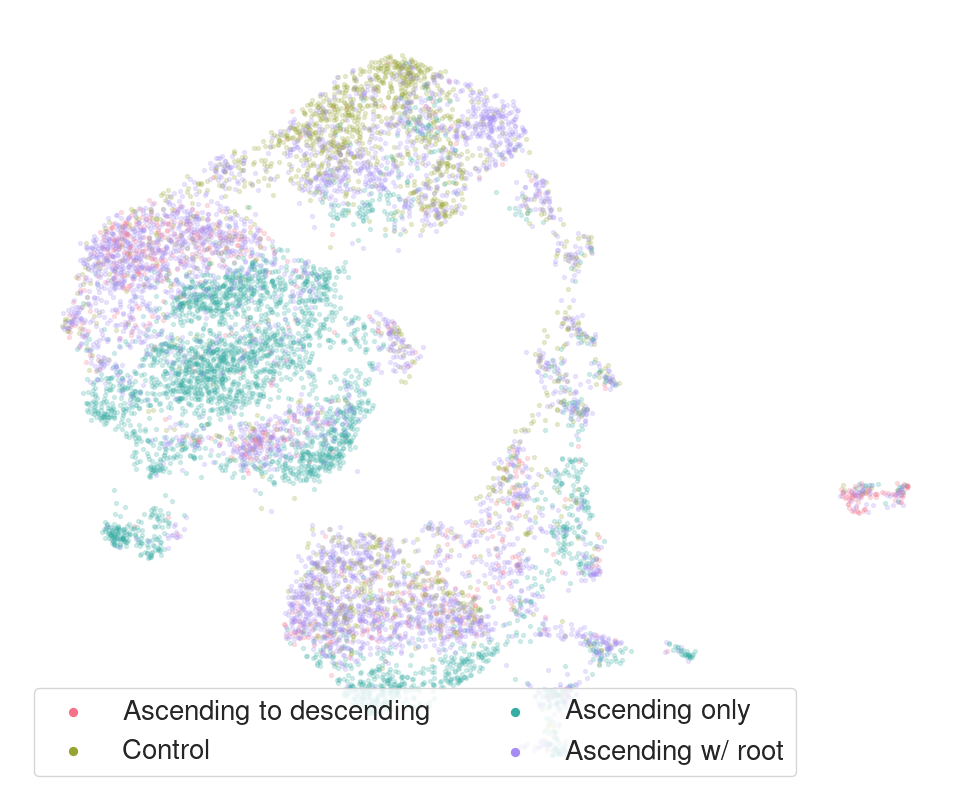

In [23]:
# Assuming sampled_adata.X.A is your input data in the form of a numpy array
# PCA dimension reduction to 50 dimensions
pca = sklearn.decomposition.PCA(n_components=50)
pca_result = pca.fit_transform(sampled_cell_aorta_gpt)
# Compute UMAP on the PCA-reduced data
embedding_sanity_check = umap.UMAP(min_dist=0.5, spread=1).fit_transform(pca_result)
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.phenotype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.phenotype==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.phenotype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_92044/3117588161.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


([], [])

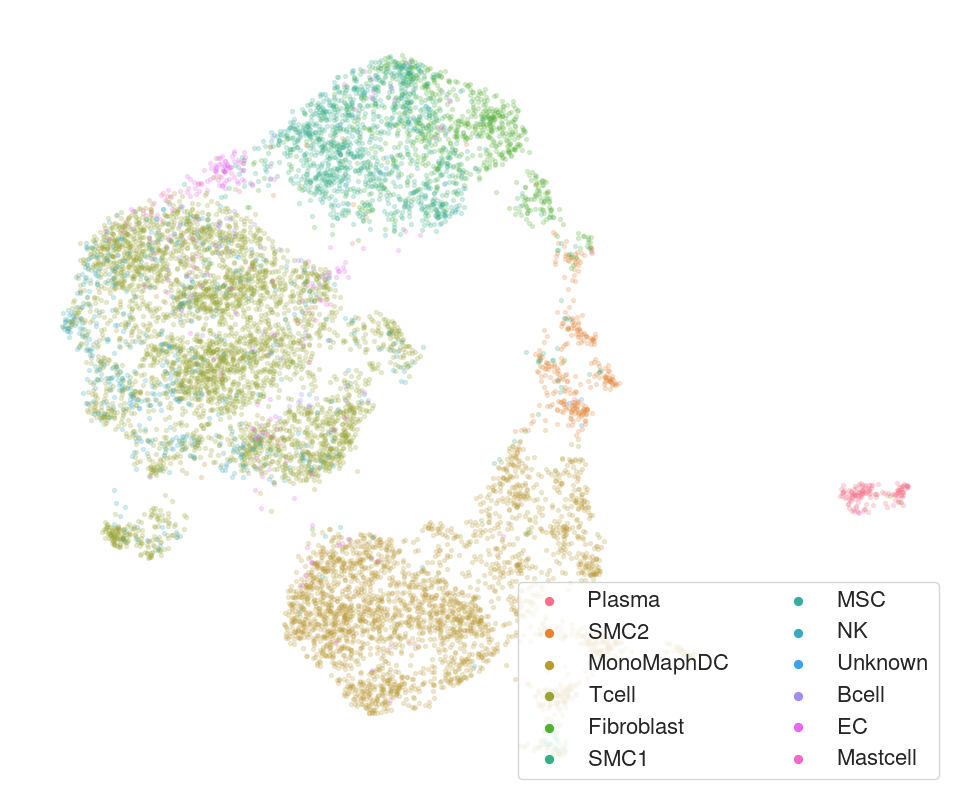

In [24]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.celltype)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.celltype==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.celltype==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
leg = plt.legend(prop={'size': 8},loc='lower right',ncol=2)
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_92044/959176283.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


([], [])

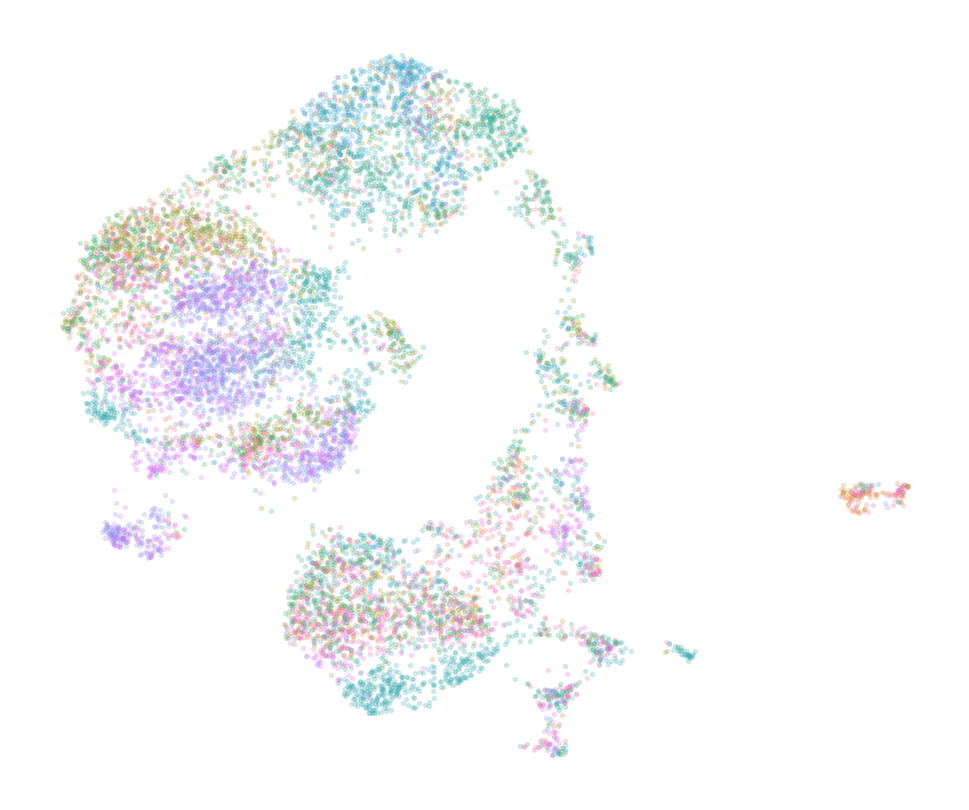

In [25]:
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
random.seed(23)
np.random.seed(2023)
all_labels = np.unique(sampled_adata.obs.patient)
random.shuffle(all_labels)
colors = sns.color_palette('husl', len(all_labels))
for i, label_name in enumerate(all_labels):
    plt.scatter(embedding_sanity_check[sampled_adata.obs.patient==label_name, 0], 
                        embedding_sanity_check[sampled_adata.obs.patient==label_name, 1], s= 2,
                        label=label_name,color=colors[i],alpha=0.2)
# leg = plt.legend(prop={'size': 10},loc='lower left',ncol=2,bbox_to_anchor=(1.1, 0.10))
plt.rcParams["legend.markerscale"] = 2.0
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xticks([])
plt.yticks([])

### Add quantitative data to measure the batch effect and the amount of biology encoded in the embeddings

In [30]:
# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(sampled_cell_aorta_gpt, 
                                                    sampled_adata.obs.phenotype,
                                                    test_size=0.20, random_state=2023)

# Verify the split
print(f"Training set size (X_train): {len(X_train)}")
print(f"Test set size (X_test): {len(X_test)}")

Training set size (X_train): 7700
Test set size (X_test): 1925


In [31]:
# oh super high accuracy! interesting... 
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(np.mean(y_test== y_pred_lr))
print(sklearn.metrics.precision_recall_fscore_support(y_test, y_pred_lr, average='weighted'))

0.7366233766233766
(0.6828793149781691, 0.7366233766233766, 0.6957723437084943, None)


/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Correlate estimated clusters to patient-level effect

In [35]:
kmeans = MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
kmeans.fit(sklearn.decomposition.PCA(n_components=50).fit_transform(X=sampled_cell_aorta_gpt))
annotation_label = sampled_adata.obs.patient
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, annotation_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label))

aRI 0.14847916234126543
aMI 0.23302600786015937


### Correlate estimated clusters to cell types

In [36]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=11, random_state=2023, batch_size=20)
kmeans.fit(sampled_cell_aorta_gpt[np.where(sampled_adata.obs.celltype!='Unknown')[0]])
annotation_label = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, annotation_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, annotation_label))

aRI 0.386182372192912
aMI 0.5266927566126255


### Correlate estimated clusters to phenotypes

In [37]:
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=4, random_state=2023, batch_size=20)
kmeans.fit(sampled_cell_aorta_gpt)
disease_label = sampled_adata.obs.phenotype
# Getting cluster centers and labels
labels = kmeans.labels_
print('aRI', sklearn.metrics.adjusted_rand_score(labels, disease_label))
print('aMI', sklearn.metrics.adjusted_mutual_info_score(labels, disease_label))
# print(pd.crosstab(labels, disease_label))

aRI 0.11488213167659007
aMI 0.10726495376587758


## Cell type annotation task
In this block, we demonstrate the performance of GenePT-s and GenePT-w embeddings on cell type annotation tasks in the Aorta dataset. 

In [9]:
with open("./GPT_3_5_gene_embeddings.pickle", "rb") as fp:
    GPT_3_5_gene_embeddings = pickle.load(fp)
gene_names= list(sampled_adata.var.index)
count_missing = 0
EMBED_DIM = 1536 # embedding dim from GPT-3.5
lookup_embed = np.zeros(shape=(len(gene_names),EMBED_DIM))
for i, gene in enumerate(gene_names):
    if gene in GPT_3_5_gene_embeddings:
        lookup_embed[i,:] = GPT_3_5_gene_embeddings[gene].flatten()
    else:
        count_missing+=1
genePT_w_emebed = np.dot(sampled_adata.X,lookup_embed)/len(gene_names)
print(f"Unable to match {count_missing} out of {len(gene_names)} genes in the GenePT-w embedding")

Unable to match 5665 out of 23331 genes in the GenePT-w embedding


### We split the Aorta dataset with annotated cell types into 80%/20% train/test split and perform a 10-nearest-neighbor classifier. 
Code credit: the set up for the 10-NN classifier was ported from the scGPT authors at https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Reference_Mapping.ipynb

#### First for GenePT-w emebddings

In [14]:
# Split the data into training and test sets (80/20)
genePT_w_emebed = genePT_w_emebed[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
genePT_w_emebed_train, genePT_w_emebed_test, y_train, y_test = train_test_split(genePT_w_emebed, 
                                                    y_celltype_remove_unknown,
                                                    test_size=0.20, random_state=2023)

In [18]:
# cell type clustering
# very quick test
k = 10  # number of neighbors
ref_cell_embeddings = genePT_w_emebed_train
test_emebd = genePT_w_emebed_test
neighbors_list_gpt_v1 = []
if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'cosine', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    # this is the true cell type
    gt = y_test[k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = mode(y_train[idx], axis=0)
    neighbors_list_gpt_v1.append(y_train[idx])
    gt_list.append(gt)
    pred_list.append(pred[0][0])
sklearn.metrics.accuracy_score(gt_list, pred_list)

/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_2146/4097584906.py:31: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred = mode(y_train[idx], axis=0)
/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_2146/4097584906.py:31: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  pred = mode(y_train[idx], axis=0)


0.8788351534061363

In [19]:
print('Precision, Recall, F1 (Marco weighted) for GenePT-w embedding: ', \
      sklearn.metrics.precision_recall_fscore_support(gt_list, pred_list,average='macro'))


Precision, Recall, F1 (Marco weighted) for GenePT-w embedding:  (0.9118915805536759, 0.6823527329148575, 0.7233963900814783, None)


#### We next do it for GenePT-s embeddings

In [21]:
# Split the data into training and test sets (80/20)
genePT_s_emebed = sampled_cell_aorta_gpt[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
y_celltype_remove_unknown = sampled_adata.obs.celltype[np.where(sampled_adata.obs.celltype!='Unknown')[0]]
genePT_s_emebed_train, genePT_s_emebed_test, y_train, y_test = train_test_split(genePT_w_emebed, 
                                                    y_celltype_remove_unknown,
                                                    test_size=0.20, random_state=2023)

In [22]:
# cell type clustering
# very quick test
k = 10  # number of neighbors
ref_cell_embeddings = genePT_s_emebed_train
test_emebd = genePT_s_emebed_test
neighbors_list_gpt_v2 = []
if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(space = 'cosine', dim = ref_cell_embeddings.shape[1]) # possible options are l2, cosine or ip
    p.init_index(max_elements = ref_cell_embeddings.shape[0], ef_construction = 200, M = 16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids = np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50) # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k = k)

idx_list=[i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    # this is the true cell type
    gt = y_test[k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings)
    pred = mode(y_train[idx], axis=0)
    neighbors_list_gpt_v2.append(y_train[idx])
    gt_list.append(gt)
    pred_list.append(pred[0][0])
sklearn.metrics.accuracy_score(gt_list, pred_list)

/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_2146/2051920383.py:31: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred = mode(y_train[idx], axis=0)
/var/folders/jr/9jmfdzzd6vgfs4_t_7ffvxn00000gn/T/ipykernel_2146/2051920383.py:31: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  pred = mode(y_train[idx], axis=0)


0.8783151326053042

In [23]:
print('Precision, Recall, F1 (Marco weighted) for GenePT-s embedding: ', \
      sklearn.metrics.precision_recall_fscore_support(gt_list, pred_list,average='macro'))

Precision, Recall, F1 (Marco weighted) for GenePT-s embedding:  (0.9113633859147423, 0.6816136346147836, 0.7224098054713864, None)
